## LLM

In [1]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, word_split, normalize_to_ascii

import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import *
from src.data_handling import read_first_n, sample_batch


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  1


In [2]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 SUPER, compute capability 7.5


In [3]:
tokenizer = pkl.load(open("tokenizers/tokenizer_CNN16000_lowercase.pkl", 'rb'))
tokenizer.create_hash()

random.seed(42)
corpus_indicies = pkl.load(open('corpus/CNN_tokenized16000_lowercase.pkl', 'rb'))
random.shuffle(corpus_indicies)

## Define Model

In [4]:
class WarmUpThenDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,
                 initial_learning_rate: float,
                 warmup_steps: int,
                 decay_schedule_fn: tf.keras.optimizers.schedules.LearningRateSchedule):
        """
        initial_learning_rate: peak LR reached at end of warmup
        warmup_steps:      # of steps to ramp from 0 → initial_learning_rate
        decay_schedule_fn: a tf.keras schedule to apply *after* warmup
        """
        super().__init__()
        self.initial_lr = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_schedule_fn = decay_schedule_fn

    def __call__(self, step):
        # Cast to float32 for safety in graph mode
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)

        # compute linear warmup: lr = initial_lr * (step / warmup_steps)
        warmup_lr = self.initial_lr * (step / warmup_steps)

        # after warmup_steps, switch to decay schedule (shift step count)
        decay_step = step - warmup_steps
        decay_lr = self.decay_schedule_fn(decay_step)

        # if step < warmup_steps, pick warmup_lr, else decay_lr
        return tf.cond(step < warmup_steps,
                       lambda: warmup_lr,
                       lambda: decay_lr)
    


In [5]:
initial_lr = 1e-4
decay_steps = 20000
decay_rate = 0.5
decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

warmup_steps = 1000
lr_schedule = WarmUpThenDecay(
    initial_learning_rate=initial_lr,
    warmup_steps=warmup_steps,
    decay_schedule_fn=decay_schedule)

np.random.seed(42)
tf.random.set_seed(42)

max_seq_len = 128
embed_dim = 700
tf_blocks = 12
heads = 10
ff_dim = 4*embed_dim
weight_decay = 0.01
dropout = 0.05

unembed_dims = []

model = Transformer(vocab_size=tokenizer.vocab_size,
                    max_seq_len=max_seq_len,
                    embed_dim=embed_dim,
                    tf_blocks=tf_blocks,
                    heads=heads,
                    ff_dim = ff_dim,
                    unembed_dims=unembed_dims,
                    lr=lr_schedule,
                    wd = weight_decay,
                    dropout=dropout,
                    )

losses_train = []
losses_test = []


In [6]:
name = "model_16k_tokens_largeBatch_12blocks"


ckpt = tf.train.Checkpoint(
    optimizer=model.opt,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/" + name,      # folder where ckpts are saved
    max_to_keep=5                         # only keep 5 latest checkpoints
)

In [7]:
ckpt.restore(ckpt_manager.latest_checkpoint)
losses_train, losses_test = pkl.load(open("checkpoints/losses_" + name + ".pkl", 'rb'))

In [96]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")

Total number of parameters: 81990270


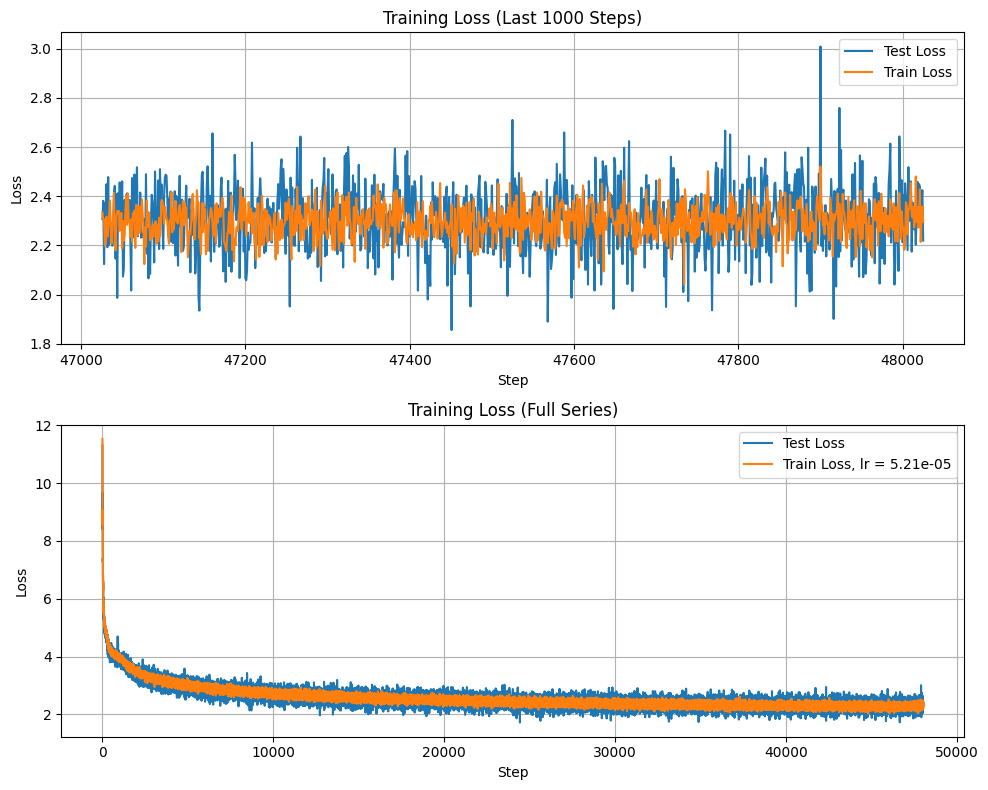

Weight Norm:  0.021810671977298756


KeyboardInterrupt: 

In [97]:
batch_size = 32
for i in tqdm(range(100000)):
    indices, y_true = sample_batch(corpus_indicies[:80000], 
                                   batch_size, 
                                   tokenizer, 
                                   max_seq_len)
    
    weight_norm = model.get_weight_norm()
    print("Weight Norm: ", weight_norm)
    loss_train = model.train_step(indices, y_true).numpy()
    losses_train.append(loss_train)
    print("Step: ", i, "Train Loss: ", loss_train)


    indices, y_true = sample_batch(corpus_indicies[80000:], 
                                batch_size//4, 
                                tokenizer, 
                                max_seq_len)
    
    loss_test = model.evaluate(indices, y_true).numpy()
        
    losses_test.append(loss_test)

    if (i+1) % 1000 == 0:
        ckpt_manager.save()
        pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))


    lr = model.opt.inner_optimizer._decayed_lr(tf.float32).numpy()
    #"""
    clear_output(wait=True)

    # prepare x-axis for the last 400 steps
    start = max(0, len(losses_train) - 1000)
    x_zoom = np.arange(start, len(losses_train))

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

    # Top subplot: zoom on last 400 steps
    ax1 = axes[0]
    ax1.plot(x_zoom, losses_test[-1000:], label="Test Loss")
    ax1.plot(x_zoom, losses_train[-1000:], label="Train Loss")

    _min = min(losses_train[-1000:] + losses_test[-1000:])
    _max = max(losses_train[-1000:] + losses_test[-1000:])
    delta = _max - _min
    #ax1.set_ylim(_min - 0.1 * delta, _max + 0.1 * delta)

    ax1.set_title("Training Loss (Last 1000 Steps)")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Bottom subplot: full series
    ax2 = axes[1]
    ax2.plot(losses_test[10:], label="Test Loss")
    ax2.plot(losses_train[10:], label="Train Loss, lr = {:.2e}".format(lr))

    ax2.set_title("Training Loss (Full Series)")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    #"""

In [8]:
print(len(losses_train))
print(np.mean(losses_train[43000:]))

48000
2.281786


In [11]:
def tokenize(indices, merge_list):
    indices = np.array(indices)
    for pair, new_idx in merge_list:
        slice = np.where(np.logical_and(indices[:-1] == pair[0],  indices[1:] == pair[1]))
        if len(slice[0]) > 0:
            indices[:-1][slice] = new_idx
            indices = np.delete(indices, (slice[0]+1))

    return tf.expand_dims(tf.convert_to_tensor(indices, dtype=tf.int32), axis=0)

In [14]:
text = "it's official:"
text = text.lower()

indices = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
indices = tokenize(indices, tokenizer.merge_list)
print(indices)

tf.Tensor([[359   1 479  27]], shape=(1, 4), dtype=int32)


In [15]:
T = 0.5
tf.random.set_seed(43)
for i in range(128):
    logits = model.call(indices)[0,-1:]
    idx = tf.cast(tf.random.categorical(logits/T, num_samples=1), tf.int32)
    indices = tf.concat([indices, idx], axis=1)
    text_pred = tokenizer.detokenize(indices)
    text_pred = text_pred.numpy()[0].decode('utf-8').replace("\n", " ")
    print(text_pred, end='\r', flush=True)
    #time.sleep(0.05)


In [17]:
text = "obama"
text = text.lower()

indices = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
indices = tokenize(indices, tokenizer.merge_list)
print(indices)

T = 0.5
tf.random.set_seed(43)
for i in range(128):
    logits = model.call(indices)[0,-1:]
    idx = tf.cast(tf.random.categorical(logits/T, num_samples=1), tf.int32)
    indices = tf.concat([indices, idx], axis=1)
    text_pred = tokenizer.detokenize(indices)
    text_pred = text_pred.numpy()[0].decode('utf-8').replace("\n", " ")
    print(text_pred, end='\r', flush=True)
    #time.sleep(0.05)


tf.Tensor([[553]], shape=(1, 1), dtype=int32)


In [22]:
text = "deepwater"
text = text.lower()

indices = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
indices = tokenize(indices, tokenizer.merge_list)
print(indices)

T = 0.5
tf.random.set_seed(43)
for i in range(128):
    logits = model.call(indices)[0,-1:]
    idx = tf.cast(tf.random.categorical(logits/T, num_samples=1), tf.int32)
    indices = tf.concat([indices, idx], axis=1)
    text_pred = tokenizer.detokenize(indices)
    text_pred = text_pred.numpy()[0].decode('utf-8').replace("\n", " ")
    print(text_pred, end='\r', flush=True)
    #time.sleep(0.05)


tf.Tensor([[13602]], shape=(1, 1), dtype=int32)


In [19]:
from sklearn.cluster import KMeans

def cosine_similarity(embed_a, embed_b):
    """
    Compute the cosine similarity between two vectors.
    """
    embed_b_T = tf.transpose(embed_b)
    dot_product = embed_a@embed_b_T
    
    norm_a = tf.linalg.norm(embed_a, axis=1, keepdims=True)
    norm_b = tf.linalg.norm(embed_b_T, axis=0, keepdims=True)

    return dot_product / (norm_a * norm_b)


def cluster(X, n_clusters, normalize=True):
    if normalize:
        X = X/np.linalg.norm(X, axis=1, keepdims=True)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    inertia = kmeans.inertia_
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_

    return inertia, labels, clusters


class EmbeddingClustering:
    def __init__(self, tokenizer, n_clusters=10):
        
        self.tokenizer = tokenizer
        self.n_clusters = n_clusters

    def fit(self, word_embed, normalize=True):
        inertia, labels, clusters = cluster(word_embed, self.n_clusters, normalize)
        self.word_embed = word_embed
        self.inertia = inertia
        self.labels = labels
        self.clusters = tf.convert_to_tensor(clusters, dtype=tf.float32)

        cos_sim = cosine_similarity(self.clusters, word_embed, normalize)
        self.idx_list =  tf.argsort(cos_sim, axis=-1, direction='DESCENDING', stable=False, name=None)

    def print_clusters(self, n_words=10):
        for idx in self.idx_list:
            for i in idx[:n_words]:
                word = self.tokenizer.detokenize(tf.expand_dims(tf.cast(i, tf.int32), axis=0))
                word = word.numpy().decode('utf-8')
                print(word)
            print("\n")


def cosine_similarity(embed_a, embed_b, normalize=True):
    """
    Compute the cosine similarity between two vectors.
    """
    if normalize:
        embed_a = tf.nn.l2_normalize(embed_a, axis=1)
        embed_b = tf.nn.l2_normalize(embed_b, axis=1)
    dot_product = embed_a@tf.transpose(embed_b)


    return dot_product

In [20]:
word_embed = model.word_embed
embedding_clustering = EmbeddingClustering(tokenizer, n_clusters=100)
embedding_clustering.fit(word_embed, normalize=True)
embedding_clustering.print_clusters(n_words=10)

afgh
infrast
fahren
riculum
usalem
onsored
palestin
cigare
dort
includ


jiang
zhang
wei
tai
iao
qing
fukus
pyong
toug
iang


school's
fbi's
band's
church's
league's
site's
club's
organization's
hotel's
department's


espion
includ
riculum
glary
usalem
jevich
ailand
{
onsored
perpe


scrut
territor
hurrican
prelim
immen
contam
vangira
peninsu
subsequ
glary


indust
espion
tournam
ailand
palestin
cathol
manh
fahren
assage
usalem


denounced
avez
upheld
reiterated
onsored
includ
embraced
surger
reviewed
otelli


onsored
surpris
avez
theless
assage
usalem
emerg
signific
propof
theast


turkish
tunisian
saudi
algerian
yemeni
danish
egyptian
colombian
european
indonesian


afgh
fahren
palestin
tournam
onsored
assage
indust
riculum
zimbab
cigare


62
40
26
28
35
27
44
36
80
85


attem
uguay
oppon
infrast
espion
assage
propof
strugg
afgh
includ


behave
abide
consume
thrive
undergo
impose
constitute
contribute
distribute
generate


verizon
palestin
nintendo
magaz
samsung
microsoft
ailand
thel

# Overlap

In [38]:
word_embed = model.word_embed

text = "russia"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed1 = tf.expand_dims(word_embed[idx[0][0]], axis=0)


text = "putin"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed2 = tf.expand_dims(word_embed[idx[0][0]], axis=0)

text = "netanyahu"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed3 = tf.expand_dims(word_embed[idx[0][0]], axis=0)

embed = embed1 - embed2 + embed3

cosine_sim = cosine_similarity(embed, word_embed, normalize=False)
idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))

tf.Tensor([[1602]], shape=(1, 1), dtype=int32)
tf.Tensor([[3512]], shape=(1, 1), dtype=int32)
tf.Tensor([[5393]], shape=(1, 1), dtype=int32)
netanyahu
russia
israel
hamas
israelis
jerusalem
tehran
kiev
gaza
palestinians
democr
beirut
azer
syria
egypt
idf
iran
britain
palestinian
abbas
tunisia
alger
lebanon
perpe
israeli
davos
brahim
controver
hezbollah
hagel
jevich
norway
fah
guinea
khamenei
cuba
anbar
utt
khamene
hezbol
weren
canada
sunnis
dipl
stoke
lavrov
aviv
karzai
israel's
arct
cambodia
zuckerberg
yanukov
yad
ukraine
pakistan
carney
netherlands
cairo
lieberman
panetta
homs
zawah
austria
espion
wawrink
vinc
libertar
libya
poland
indonesia
liby
merkel
pyongyang
tik
airstrikes
ibrahimovic
abe
iran's
yugo
kass
mosul
galax
yemen
scotland
settlements
sudan
nuri
niger
palestine
tsvangira
ieval
iaea
denmark
hmer
tahrir
nusra
sarkoz
ukrain
bolivia


In [ ]:
word_embed = model.word_embed

text = "israel"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed = tf.expand_dims(word_embed[idx[0][0]], axis=0)

cosine_sim = embed@tf.transpose(word_embed)
idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))

tf.Tensor([[1617]], shape=(1, 1), dtype=int32)
israel
gaza
hamas
netanyahu
israel's
israeli
jerusalem
israelis
idf
lebanon
palestinians
iran
egypt
palestinian
palestine
tehran
hezbollah
syria
cairo
pakistan
bolivia
iranians
iraq
sinai
turkey
britain
venezuela
russia
ukraine
tunnels
egyptian
misrata
norway
sudan
cuba
pyongyang
egypt's
canada
moscow
beirut
nigeria
germany
kenya
allah
sarkoz
libya
travolta
japan
nusra
assad's
aq
mubarak
isis
tunisia
france
greece
aviv
1967
ahmadinejad
damascus
jewish
myanmar
syrians
abbas
iranian
isaf
khamenei
merkel
baghdad
croatia
kiev
lebanese
sudan's
tibet
spain
iran's
afghanistan
chile
rouhani
america
annan
algeria
kurdistan
turkish
ireland
khamene
aleppo
hani
jews
sweden
egyptians
colombia
morsy
nato
awlaki
gbagbo
yemeni
fah
burma
gadhafi's


In [41]:
word_embed = model.word_embed

text = "netanyahu"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed = tf.expand_dims(word_embed[idx[0][0]], axis=0)

cosine_sim = embed@tf.transpose(word_embed)
idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))

tf.Tensor([[5393]], shape=(1, 1), dtype=int32)
netanyahu
abulary
hagel
maduro
espion
yingluck
onsored
nandez
saleh
natur
ailand
hezbol
panetta
biden
shinse
kerry
gibbs
sarkozy
fundam
hift
patro
signific
anonymity
putin
mugabe
lades
boehner
pelosi
medvedev
ahmadinejad
warri
thaksin
landrieu
shaba
gbag
accust
charac
fahren
liby
peninsu
helicop
zuma
traged
portugu
morsy
publ
enjo
ilight
abbas
erdogan
ieval
bachmann
yanukovych
leep
confir
rodrigue
secutive
provin
mccain's
moil
subsequ
abled
juvent
o'ne
guardiola
lieberman
karzai
catastro
ouatt
zardari
possib
toug
theless
burma
carney
ricul
zhok
barcelon
dort
sunnis
lomb
snowden
avez
diffic
sess
khamenei
exer
golese
copen
rouhani
ipal
transparen
ultane
mccain
boeh
diox
citiz
adjac
nieto
lavrov


## Mean Pooling

In [92]:
word_embed = model.word_embed

text = "Obama's remarks came shortly after U.N. inspectors left Syria, carrying evidence that will determine whether chemical weapons were used in an attack early last week in a Damascus suburb."
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx.shape)
embed_final = model.call(idx, logits=False)
#embed_mean = embed_final[:,-1,:]
embed_mean = tf.reduce_mean(embed_final, axis=1)
embed_mean = tf.cast(embed_mean, dtype=tf.float32) 

cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=False)
#cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=True)

idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))


(1, 62)
 
.
-
"
,
a
in


and
the
on
to
at
'
an
or
u
by
that
:
as
's
s
al
of
it
he
for
un
over
e
about
is
with
after
up
not
last
more
may
?
re
from
ad
(
state
be
just
so
was
one
/
ed
no
war
while
security
;
but
1
en
n
man
house
i
north
m
first
ar
l
f
c
er
there
out
o
do
two
when
less
had
air
k
v
h
near
they
2
his
some
de
back
we
field
fire
if
this
under
p
right


In [ ]:
word_embed = model.word_embed

text = "Obama"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
b = model.unembed_b[idx[0][0]]
print(b)
logits = model.call(idx, logits=True) 
#embed_mean = embed_final[:,-1,:]
embed_mean = tf.reduce_mean(embed_final, axis=1)
embed_mean = tf.cast(embed_mean, dtype=tf.float32)

cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=False)
#cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=True)

idx = tf.argsort(logits, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(i)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))


tf.Tensor([[553]], shape=(1, 1), dtype=int32)
tf.Tensor(0.08745351, shape=(), dtype=float32)
tf.Tensor([[    1    13    15 ... 15466  9736 15505]], shape=(1, 16070), dtype=int32)


AttributeError: 'numpy.ndarray' object has no attribute 'decode'

## 